In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

# Getting the data

As always, let's import our last updated data.

In [2]:
from utils import load_datasets

gru_data_folder = os.path.join(parent_dir, "3_preprocessing", "output", "gru")
gru_train_set, gru_val_set, gru_test_set = load_datasets(folder=gru_data_folder)

grubert_data_folder = os.path.join(parent_dir, "3_preprocessing", "output", "grubert")
grubert_train_set, grubert_val_set, grubert_test_set = load_datasets(folder=grubert_data_folder)

In [3]:
gru_train_set.head()

,Unnamed: 0,iro,text,prob
0,210,0,le nuove opportunità per tutti i docenti: for...,0.000000
1,2863,0,"<mention> mah, io sono un fan sfegatato del go...",0.000000
2,1042,0,"#labuonascuola allo yif, mengucci ' la vera fo...",0.113402
3,2708,0,"lettera aperta dell'ali a mario monti, con pol...",0.000000
4,849,0,"<mention> <mention> ci sono 250 scuole, senza ...",0.000000


# Baselines
Our main baselines are the results of the [2016 edition of the EvalITA challenge](), which was the one for which our dataset was released:


![evalita_results](evalita_results.png)   

Moreover, we use **two dummy baselines** for our models: one with a random strategy and one with a majority strategy.
We store the predictions of both the validation and the test sets.  

In [4]:
from sklearn.dummy import DummyClassifier

dummy_majority = DummyClassifier(strategy="most_frequent")
dummy_random = DummyClassifier(strategy="uniform")

X_train = gru_train_set['text']
y_train = gru_train_set[['iro']]

In [5]:
dummy_majority.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [6]:
dummy_random.fit(X_train, y_train)

DummyClassifier(strategy='uniform')

In [7]:
X_val = gru_val_set['text']
y_val = gru_val_set['iro']

# Predicting the val set with the dummies
y_pred_majority_val = dummy_majority.predict(X_val)
y_pred_random_val = dummy_random.predict(X_val)

In [8]:
X_test = gru_test_set['text']
y_test = gru_test_set['iro']

# Predicting the test set with the dummies
y_pred_majority_test = dummy_majority.predict(X_test)
y_pred_random_test = dummy_random.predict(X_test)

In [9]:
# Storing all the results to parent_dir/4_baselines_and_models/output

output_folder = os.path.join(parent_dir, "4_baselines_and_models", "output")
os.makedirs(output_folder, exist_ok=True)

# Saving the predictions for the val set
gru_val_set['iro_pred_majority'] = y_pred_majority_val
gru_val_set['iro_pred_random'] = y_pred_random_val
gru_val_set.to_csv(os.path.join(output_folder, "val_set_baselines.csv"), index=False)

# Saving the predictions for the test set
gru_test_set['iro_pred_majority'] = y_pred_majority_test
gru_test_set['iro_pred_random'] = y_pred_random_test
gru_test_set.to_csv(os.path.join(output_folder, "test_set_baselines.csv"), index=False)

# Input Format

We have thought of 3 possible formats for our inputs. In order to take a look at them, we build an instance of our vocabulary (which we will cover in detail in the following section).

In [10]:
import gensim
from vocabulary import BaseTokenizer, Vocabulary

embedding_model_path = os.path.join(parent_dir, "embedding_models", "italian_word2vec_100.bin")
embedding_model = gensim.models.KeyedVectors.load_word2vec_format(embedding_model_path, binary=True)
gru_tokenizer = BaseTokenizer()

vocab = Vocabulary(
    dataset=gru_train_set,
    embedding_model=embedding_model,
    tokenizer=gru_tokenizer,
    embedding_size=100
)

vocab.create_vocabulary(verbose=True)

No cached vocabulary loaded. Building vocabulary from scratch...
[1/5] Tokenizing...
[2/5] Checking for new terms...
	Total new terms: 2830 (16.78%)
[3/5] Merging new terms...
[4/5] Getting word_to_idx and idx_to_word...
[5/5] Building embedding matrix...
Done!


### Base Case: Simple embeddings
The base case is to use simply the **vector of integer embedding indices**, padded or truncated to match our chosen max lenght of 50.  

In [12]:
from CustomDataset import GRUDataset, CustomDataset
from transformers import AutoTokenizer

gru_train_dataset = GRUDataset(
    dataframe=gru_train_set,
    vocabulary=vocab,
    tokenizer=gru_tokenizer,
    max_len=50
)

grubert_tokenizer = AutoTokenizer.from_pretrained("m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0")
grubert_train_dataset = CustomDataset(
    dataframe=grubert_train_set,
    tokenizer=grubert_tokenizer,
    max_len=50
)

In [34]:
for i in range(1):
    print(gru_train_dataset[i])

{'inputs': tensor([     10,     401, 2470935,      12,      49,       9,    3165,      18,
            565,       7,    1130, 2469443,     440,     324,    5213,    2381,
            364,    2073,   10823,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,       0,
              0,       0]), 'targets': tensor(0.)}


In [35]:
for i in range(1):
    print(grubert_train_dataset[i])

{'ids': tensor([     2,     40,    833,  22506,     22,     33,     31,   3821,      1,
          1944,     13,   2344,    126,    159,     81,      6,  14013,    902,
        127748,      1,   1088,      3,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0]), 'mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]), 'targets': tensor(0.)}


Considering a batch of B elements, a sequence of max len M we would have an input of integers with dimension

$$
(B, M)
$$

After the embedding lookup, the dimension would be

$$
(B, M, E)
$$

### Enrichment 1: Embeddings + Pos Tags

On top of the base case, [it has been found beneficial](https://aclanthology.org/S18-1006/) to use **pos tags** as additional input for the model, probably because of the common syntactic patterns that ironic statements have. Therefore, a second input version that we utilize is one that concatenates the one-hot-encoding of the pos tag of each token in the dimension of the embeddings.  

We used the SpaCy model `it_core_news_md`, that contains italian-specific tags, to extract them.  

Let's see what the dataset entry looks like with pos tags.

In [40]:
from CustomDataset import GRUDataset, CustomDataset
from transformers import AutoTokenizer

gru_train_dataset = GRUDataset(
    dataframe=gru_train_set,
    vocabulary=vocab,
    tokenizer=gru_tokenizer,
    max_len=50,
    pos_tags=True # <---
)

grubert_tokenizer = AutoTokenizer.from_pretrained("m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0")
grubert_train_dataset = CustomDataset(
    dataframe=grubert_train_set,
    tokenizer=grubert_tokenizer,
    max_len=50,
    pos_tags=True # <---
)

c:\Users\giorg\miniconda3\envs\torch\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [41]:
for i in range(1):
    print(gru_train_dataset[i])

{'inputs': tensor([     10,     401, 2470935,      12,      49,       9,    3165,      18,
            565,       7,    1130, 2469443,     440,     324,    5213,    2381,
            364,    2073,   10823,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,       0,
              0,       0]), 'targets': tensor(0.), 'pos_tags': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])}


In [42]:
for i in range(1):
    print(grubert_train_dataset[i])

{'ids': tensor([     2,     40,    833,  22506,     22,     33,     31,   3821,      1,
          1944,     13,   2344,    126,    159,     81,      6,  14013,    902,
        127748,      1,   1088,      3,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0]), 'mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]), 'targets': tensor(0.), 'pos_tags': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0,

Considering a batch of B elements, a sequence of max len M we would have an input of integers with dimension

$$
(B, M)
$$

After the embedding lookup, we concatenate the one-hot-encoding of the pos tags to the tensor in the dimension of the embeddings.  
Therefore, if we have P possible tags, the dimension of the tensor ater the embedding look-up becomes

$$
(B, M, E+P)
$$

### Enrichment 2: Embeddings + Pos Tags + Hashtag Enrichment  

Finally, we can use the **hashtag enrichment** piece of information. Because this is a simple high-level logit, and we do not want it to be overwhelmed by the lots of tokens of a tweet, we do not pass this as input at the beginning of the network, but we **concatenate it to the input of the classification head** at the end of the network.

In [43]:
from CustomDataset import GRUDataset, CustomDataset
from transformers import AutoTokenizer

gru_train_dataset = GRUDataset(
    dataframe=gru_train_set,
    vocabulary=vocab,
    tokenizer=gru_tokenizer,
    max_len=50,
    pos_tags=True,
    text_enrichment=True # <---
)

grubert_tokenizer = AutoTokenizer.from_pretrained("m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0")
grubert_train_dataset = CustomDataset(
    dataframe=grubert_train_set,
    tokenizer=grubert_tokenizer,
    max_len=50,
    pos_tags=True,
    text_enrichment=True # <---
)

c:\Users\giorg\miniconda3\envs\torch\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [44]:
for i in range(1):
    print(gru_train_dataset[i])

{'inputs': tensor([     10,     401, 2470935,      12,      49,       9,    3165,      18,
            565,       7,    1130, 2469443,     440,     324,    5213,    2381,
            364,    2073,   10823,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0,       0,       0,       0,
              0,       0]), 'targets': tensor(0.), 'probs': tensor(0.), 'pos_tags': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])}


In [45]:
for i in range(1):
    print(grubert_train_dataset[i])

{'ids': tensor([     2,     40,    833,  22506,     22,     33,     31,   3821,      1,
          1944,     13,   2344,    126,    159,     81,      6,  14013,    902,
        127748,      1,   1088,      3,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0]), 'mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]), 'targets': tensor(0.), 'pos_tags': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0,

# Our models

We are ready to take a look at the architectures.

## Gru Model

Our first model is a Gru-based one.  

### Embedding model and Tokenizer

The input for this model is obtained using a **dense embedding model**, with the following characteristics:  
- **Embedding dimension**: 100;
- **Window size**: 10;
- **Corpus**: Italian CoNLL17 corpus  (Vocab size: 2469122);
- **Algorithm**: Word2Vec Continuous Skipgram

The **tokenizer** we used is the nltk BaseTokenizer, with language italian.

In this section, we check their compatibility by giving both **quantitative evidence** (coverage, number of oov tokens) and **qualitative evidence** (sample tokens to perform vector space semantics).

In [26]:
# 3. Check coverage (quantitative measure of OOV vs. known tokens)
vocab.check_coverage()

----- Coverage Check -----
Total unique tokens in dataset: 16861
Number of OOV (new) terms:      2830
Number of known tokens:         14031
Coverage ratio:                 83.22%



In [27]:
# 4. Check a few words for semantic consistency
vocab.check_semantics(["governo", "decreto", "pizza", "sfiga"])

----- Semantic Check -----

Most similar words to 'governo':
   parlamento (score=0.847)
   govenro (score=0.836)
   ilgoverno (score=0.818)
   moldovo (score=0.818)
   ganzouri (score=0.816)

Most similar words to 'decreto':
   dpcm (score=0.884)
   legislativo (score=0.870)
   ministeriale (score=0.855)
   d.l. (score=0.847)
   interministeriale (score=0.846)

Most similar words to 'pizza':
   taglioimpasto (score=0.835)
   pizzetta (score=0.808)
   crepes (score=0.800)
   pepperoni (score=0.800)
   picanha (score=0.794)

Most similar words to 'sfiga':
   sfortuna (score=0.829)
   iella (score=0.800)
   sfortuna.. (score=0.794)
   finaccia (score=0.789)
   jella (score=0.784)



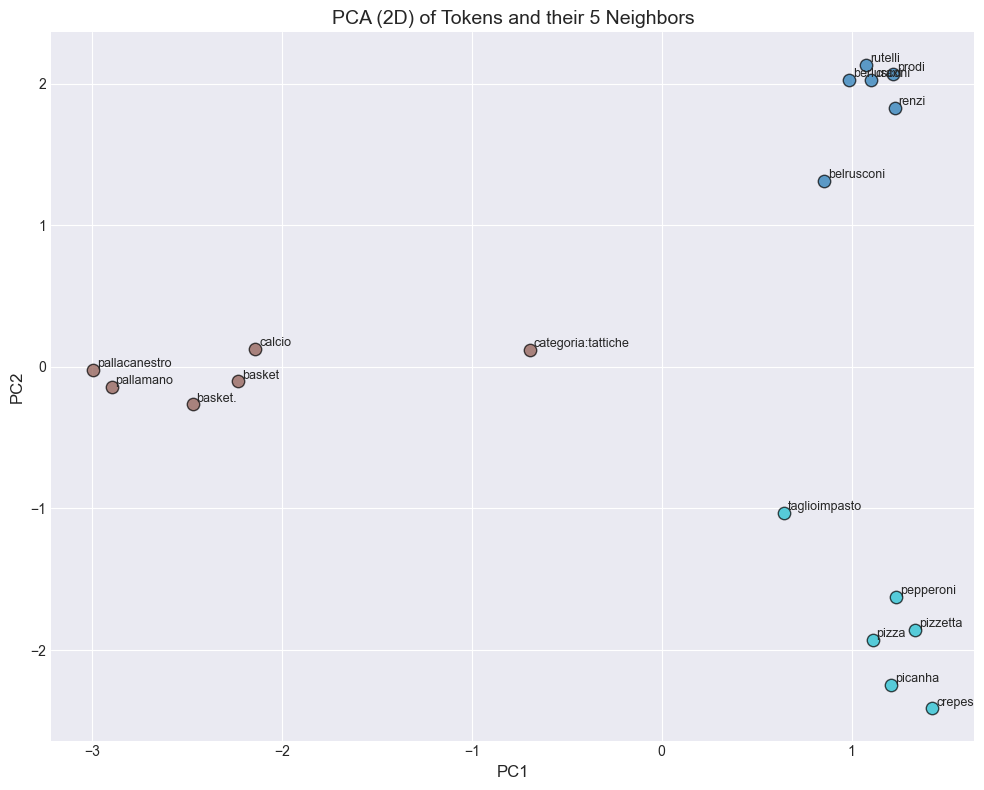

In [33]:
vocab.plot_tokens_and_neighbors(['berlusconi', 'calcio', 'pizza'])

In [28]:
# 5. Explain why random OOV is used
vocab.justify_random_oov()

----- Justification for Random OOV Handling -----
Out of 16861 total unique tokens, 2830 (16.78%) are new/OOV.

1. Since the OOV percentage is relatively small, assigning random vectors to these tokens is not likely to drastically impact overall performance.
2. This approach keeps all dimensionalities consistent and prevents the model from discarding or ignoring unseen tokens.
3. If we later fine-tune the model, these random embeddings can adapt to reflect actual usage of OOV terms.
4. This balances practicality (no data loss) with a minimal overhead for a small fraction of unknown words.



### Model Architecture

The Gru model is composed of the following blocks:
1. An **Embedding lookup layer** which maps the embedding indices received as input to the corresponding embeddings.
2. A **bidirectional GRU module**, which processes the tweets to extract the high-level, linearly separable info.
3. A **linear classification head**, that takes the two last hidden states of the GRU module (they are two beacuse the GRU is bidirectional) to output a (sigmoided) logit.

## GruBERT Model

Our second model is called **GruBERT**, and it differs from the first one as it does not use simple word2vec embeddings but a **fully-fledged Bert Encoder**. For the rest, the architecture is identical. Therefore, other than analyzing the impacts of text enrichment, with both hashtags and pos tags, we aim at getting a measure of the margin that a bigger (100 vs 768) and Transformer-based embedding can bring.

### Bert Encoder and Tokenizer chosen

We chose [**AlBERTo**](https://ceur-ws.org/Vol-2481/paper57.pdf) as our BERT encoder and tokenizer.

AlBERTo is an Italian BERT pre-trained over our dataset.  
The model was fine-tuned four times: once for subjectivity, once for positive polarity detection, once for negative polarity detection and once for irony detection, using all sets of labels contained in the dataset. The chosen learning rate was 2e-5 with 1000 steps per loops on batches of 512 examples. 

We consider AlBERTo's pre-training results as another baseline for our models.

### Model Architecture

The Gru model is composed of the following blocks:


1. A **Bert Encoder** which maps the embedding indices, attention masks and token type ids received as input to the corresponding embeddings.
2. A **bidirectional GRU module**, which processes the tweets to extract the high-level, linearly separable info.
3. A **linear classification head**, that takes the two last hidden states of the GRU module (they are two beacuse the GRU is bidirectional) to output a (sigmoided) logit.